In this tutorial, we'll get familiar with the **image classification** using Convolutional Neural Network models.

In [1]:
import torch

# Pytorch Basics: Tensors & Gradients

##Tensors

At its core, PyTorch is a library for processing tensors. A tensor is a number, vector, matrix or any n-dimensional array. Let's create a tensor with a single number:

In [2]:
# Number
t1 = torch.tensor(4.)
print(t1.dtype)
t1

torch.float32


tensor(4.)

In [3]:
# Vector
t2 = torch.tensor([1., 2, 3, 4])
t2

tensor([1., 2., 3., 4.])

In [ ]:
# Matrix
t3 = torch.tensor([[5., 6],
                   [7, 8],
                   [9, 10]])
t3

tensor([[ 5.,  6.],
        [ 7.,  8.],
        [ 9., 10.]])

In [ ]:
# 3-dimensional array
t4 = torch.tensor([
    [[11, 12, 13],
     [13, 14, 15]],
    [[15, 16, 17],
     [17, 18, 19.]]])
t4

tensor([[[11., 12., 13.],
         [13., 14., 15.]],

        [[15., 16., 17.],
         [17., 18., 19.]]])

Tensors can have any number of dimensions, and different lengths along each dimension. We can inspect the length along each dimension using the .shape property of a tensor.

In [ ]:
print(t1.shape)
print(t2.shape)
print(t3.shape)
print(t4.shape)

torch.Size([])
torch.Size([4])
torch.Size([3, 2])
torch.Size([2, 2, 3])


##Tensor operations and gradients
We can combine tensors with the usual arithmetic operations. Let's look an example:

In [ ]:
# Create tensors.
x = torch.tensor(3., requires_grad=True)
w = torch.tensor(4., )
b = torch.tensor(5., )
x, w, b

(tensor(3., requires_grad=True), tensor(4.), tensor(5.))

We've created 3 tensors x, w and b, all numbers. w and b have an additional parameter requires_grad set to True. We'll see what it does in just a moment.
Let's create a new tensor y by combining these tensors:


In [ ]:
# Arithmetic operations
y = w * x + b
y

tensor(17., grad_fn=<AddBackward0>)

As expected, y is a tensor with the value 3 * 4 + 5 = 17. What makes PyTorch special is that we can automatically compute the derivative of y w.r.t. the tensors that have requires_grad set to True i.e. x. To compute the derivatives, we can call the .backward method on our result y.

In [ ]:
# Compute derivatives
y.backward()

In [ ]:
# Display gradients
print('dy/dx:', x.grad)
print('dy/dw:', w.grad)
print('dy/db:', b.grad)

dy/dx: tensor(4.)
dy/dw: None
dy/db: None


As expected, dy/dx has the same value as w i.e. 4. Note that w.grad is None and b.grad is None, because w and b don't have requires_grad set to True.
The "grad" in x.grad stands for gradient, which is another term for derivative, used mainly when dealing with matrices.

### Further Reading ###
Tensors in PyTorch support a variety of operations, and what we've covered here is by no means exhaustive. You can learn more about tensors and tensor operations here: https://pytorch.org/docs/stable/tensors.html

# Image Classification using Convolutional Neural Networks in PyTorch


**Using a GPU for faster training**

You can use a **Graphics Processing Unit (GPU)** to train your models faster if your execution platform is connected to a GPU manufactured by NVIDIA. Follow these instructions to use a GPU on the platform of your choice:

Google Colab: Use the menu option **"Runtime > Change Runtime Type" and select "GPU" from the "Hardware Accelerator" dropdown**.

## Load CIFAR-10 Dataset ##
For this tutorial, we'll use the CIFAR10 dataset, which consists of 60000 32x32 px colour images in 10 classes.

In [1]:
import os
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])])

trainset = torchvision.datasets.CIFAR10(root='./data',
                                        train=True,
                                        download=True,
                                        transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data',
                                       train=False,
                                       download=True,
                                       transform=transform)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170M/170M [00:03<00:00, 48.8MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
BATCH_SIZE = 4
trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True,
                                          num_workers=2)
testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=BATCH_SIZE,
                                         shuffle=False,
                                         num_workers=2)

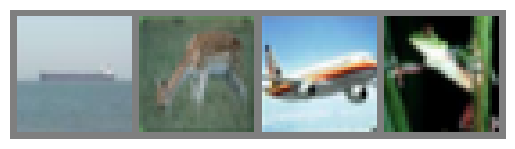

 ship  deer plane  frog


In [ ]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(BATCH_SIZE)))

## Define a Convolution Neural Network
Define a neural network that takes 3-channel images.

<!-- ![Getting Started](./img.jpg)
![Getting Started](img.jpg) -->

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self, activation_function=F.relu):
        """
        Args:
            activation_function (function): Activation function to use (e.g., F.relu, F.sigmoid, F.tanh).
        """
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.activation_function = activation_function

    def forward(self, x):
        x = self.pool(self.activation_function(self.conv1(x)))
        x = self.pool(self.activation_function(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = self.activation_function(self.fc1(x))
        x = self.activation_function(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

Define a Loss function and optimizer

Let's use a Classification Cross-Entropy loss and SGD with momentum.

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## Train the Network ##

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [8]:
from tqdm import tqdm
def train(model, device, train_loader, optimizer, epoch, criterion):
    """
    Train the model for one epoch.

    Args:
        model: The neural network model to be trained.
        device: Device to perform training ('cpu' or 'cuda').
        train_loader: DataLoader for the training data.
        optimizer: Optimizer for updating model weights.
        epoch: Current epoch number.
        scheduler: Learning rate scheduler (can be None).
        criterion: Loss function.

    Returns:
        train_loss: Average training loss for the epoch.
    """
    model.train()  # Set model to training mode
    correct = 0
    processed = 0
    running_loss = 0.0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch}")
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()  # Reset gradients
        y_pred = model(data)  # Forward pass
        loss = criterion(y_pred, target)  # Compute loss

        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        # if scheduler:
        #     scheduler.step()  # Adjust learning rate

        # Update metrics
        running_loss += loss.item()
        pred = y_pred.argmax(dim=1, keepdim=True)  # Get predictions
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        # Update progress bar
        accuracy = 100 * correct / processed
        pbar.set_description(
            f"Epoch ={epoch} Batch={batch_idx} Train Loss={loss.item():.4f}"
        )

    train_loss = running_loss / len(train_loader)
    return train_loss

In [9]:
def test(model, device, test_loader, criterion):
    """
    Evaluate the model on the test set.

    Args:
        model: The neural network model to be evaluated.
        device: Device to perform evaluation ('cpu' or 'cuda').
        test_loader: DataLoader for the test data.
        criterion: Loss function.

    Returns:
        test_loss: Average test loss for the epoch.
        test_accuracy: Test accuracy for the epoch.
    """
    model.eval()  # Set model to evaluation mode
    test_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing"):
            # Move data to the specified device (CPU/GPU)
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)  # Get probabilities
            all_probs.append(probs.cpu().numpy())

            loss = criterion(outputs, labels)
            test_loss += loss.item()

            # Get predictions
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Store labels and predictions for further evaluation
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # Calculate accuracy
    accuracy = 100 * correct / total

    # Calculate average loss
    avg_loss = test_loss / len(test_loader)

    # Print results
    print(f"Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.2f}%")

    return avg_loss, accuracy, all_labels, all_predictions, all_probs

In [ ]:
net = net.to(device)
num_epochs = 2
train_loss_history = []
test_loss_history = []

for epoch in range(1, num_epochs + 1):
    train_loss = train(net, device, trainloader, optimizer, epoch, criterion)
    train_loss_history.append(train_loss)

    test_loss, test_accuracy, all_labels, all_predictions, all_probs = test(net, device, testloader, criterion)
    test_loss_history.append(test_loss)

PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

Testing: 100%|██████████| 2500/2500 [00:14<00:00, 176.36it/s]


Test Loss: 1.3886, Test Accuracy: 50.12%


Testing: 100%|██████████| 2500/2500 [00:12<00:00, 192.95it/s]

Test Loss: 1.3034, Test Accuracy: 53.90%


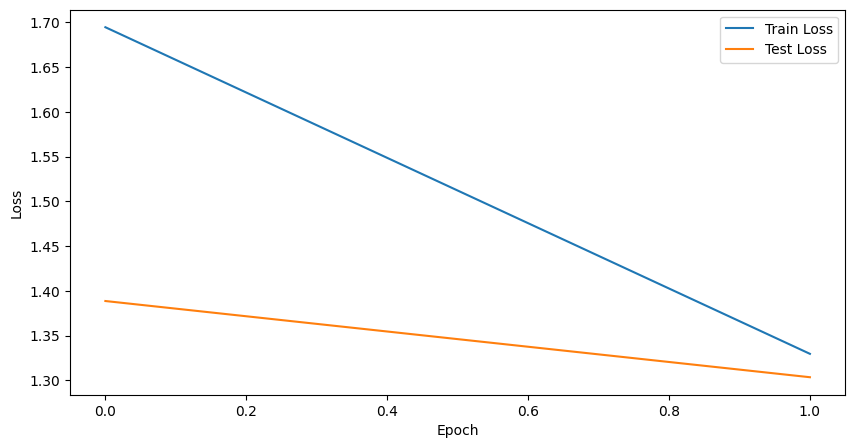

In [ ]:
# Plot the loss curves
plt.figure(figsize=(10, 5))
plt.plot(train_loss_history, label="Train Loss")
plt.plot(test_loss_history, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Model Evaluation ##

In [ ]:
from sklearn.metrics import classification_report, accuracy_score
report = classification_report(all_labels, all_predictions, target_names=classes)
print("\nClassification Report:\n")
print(report)


Classification Report:

              precision    recall  f1-score   support

       plane       0.59      0.62      0.60      1000
         car       0.47      0.86      0.61      1000
        bird       0.58      0.28      0.37      1000
         cat       0.38      0.43      0.40      1000
        deer       0.54      0.40      0.46      1000
         dog       0.57      0.37      0.45      1000
        frog       0.57      0.73      0.64      1000
       horse       0.73      0.51      0.60      1000
        ship       0.58      0.76      0.66      1000
       truck       0.54      0.44      0.48      1000

    accuracy                           0.54     10000
   macro avg       0.55      0.54      0.53     10000
weighted avg       0.55      0.54      0.53     10000



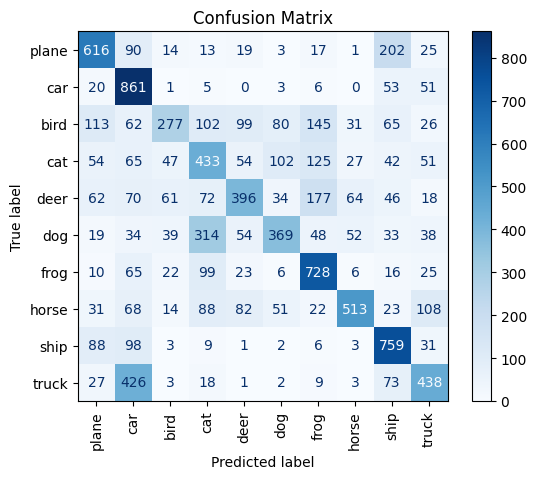

In [ ]:
#Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Compute confusion matrix
cm = confusion_matrix(all_labels, all_predictions)
# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')

plt.title("Confusion Matrix")
plt.show()

To draw an AUC-ROC (Area Under the Receiver Operating Characteristic curve) for a multi-class classification problem, you need to compute the ROC curve and AUC score for each class. 

**Steps to Plot AUC-ROC Curve**
1. Obtain Class Probabilities: Instead of torch.max to get predictions, use the raw output (logits) and apply torch.softmax to get class probabilities.
2. Binarize the Labels: Convert the multi-class labels into a binary format for ROC computation.
3. Compute ROC Curves and AUC Scores: Use roc_curve and auc functions from sklearn.metrics.
4. Plot the ROC Curves: Visualize the ROC curves for each class and optionally include the macro-averaged ROC curve.


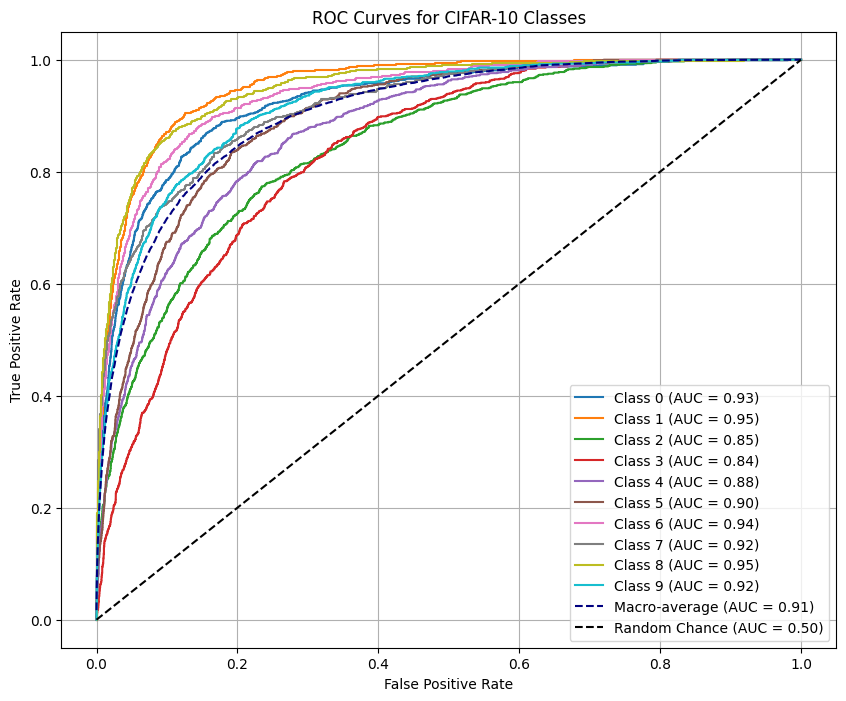

In [ ]:
#ROC Curve
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Number of classes
num_classes = 10

all_probs = np.vstack(all_probs)
all_labels = np.hstack(all_labels)

# Binarize the labels for multi-class ROC
all_labels_binarized = label_binarize(all_labels, classes=np.arange(num_classes))

# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(all_labels_binarized[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute macro-average ROC curve and AUC
fpr["macro"], tpr["macro"] = np.unique(np.concatenate([fpr[i] for i in range(num_classes)])), None
tpr["macro"] = np.mean([np.interp(fpr["macro"], fpr[i], tpr[i]) for i in range(num_classes)], axis=0)
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot the ROC curves
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")
plt.plot(fpr["macro"], tpr["macro"], color='navy', linestyle='--', label=f"Macro-average (AUC = {roc_auc['macro']:.2f})")

# Diagonal line for random chance
plt.plot([0, 1], [0, 1], 'k--', label="Random Chance (AUC = 0.50)")

# Customize the plot
plt.title("ROC Curves for CIFAR-10 Classes")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [ ]:
#Model Summary
from torchsummary import summary
summary(net, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         MaxPool2d-4             [-1, 16, 5, 5]               0
            Linear-5                  [-1, 120]          48,120
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 0.24
Estimated Total Size (MB): 0.31
----------------------------------------------------------------


## Play with model

In [ ]:
#TODO: Use different BATCH_SIZE and see how results change

In [ ]:
#TODO: Use different activation function and see how results change

# TRANSFER LEARNING

### Use ResNet18 pretrained on ImageNet dataset containing approximately 1.28 million training images and 1,000 classes ###

In [3]:
transform = transforms.Compose(
    [#transforms.Resize(224),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])])

trainset = torchvision.datasets.CIFAR10(root='./data',
                                        train=True,
                                        download=True,
                                        transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data',
                                       train=False,
                                       download=True,
                                       transform=transform)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [4]:
BATCH_SIZE = 4
trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True,
                                          num_workers=2)
testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=BATCH_SIZE,
                                         shuffle=False,
                                         num_workers=2)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [6]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision
class ResNet18_CIFAR10(nn.Module):
    def __init__(self):
        super().__init__()
        base = torchvision.models.resnet18(weights='IMAGENET1K_V1')
        self.base = nn.Sequential(*list(base.children())[:-1])
        in_features = base.fc.in_features
        self.drop = nn.Dropout()
        self.final = nn.Linear(in_features,10)

    def forward(self,x):
        x = self.base(x)
        x = self.drop(x.view(-1,self.final.in_features))
        return self.final(x)

model_resnet18 = ResNet18_CIFAR10()
optimizer = torch.optim.SGD(model_resnet18.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [ ]:
model_resnet18 = model_resnet18.to(device)
num_epochs = 5
train_loss_history_resnet18 = []
test_loss_history_resnet18 = []

for epoch in range(1, num_epochs + 1):
    train_loss = train(model_resnet18, device, trainloader, optimizer, epoch, criterion)
    train_loss_history_resnet18.append(train_loss)

    test_loss, test_accuracy, all_labels, all_predictions, all_probs = test(model_resnet18, device, testloader, criterion)
    test_loss_history_resnet18.append(test_loss)

Testing: 100%|██████████| 2500/2500 [00:32<00:00, 76.76it/s] 


Test Loss: 1.1816, Test Accuracy: 62.08%


Testing: 100%|██████████| 2500/2500 [00:31<00:00, 78.58it/s] 


Test Loss: 1.0469, Test Accuracy: 68.32%


Testing: 100%|██████████| 2500/2500 [00:33<00:00, 75.35it/s] 


Test Loss: 0.9734, Test Accuracy: 71.85%


Testing: 100%|██████████| 2500/2500 [00:33<00:00, 75.03it/s] 


Test Loss: 0.9353, Test Accuracy: 73.73%


Testing: 100%|██████████| 2500/2500 [00:33<00:00, 74.77it/s] 

Test Loss: 0.9233, Test Accuracy: 72.53%


NameError: name 'net' is not defined

In [14]:
PATH = './cifar_resnet18.pth'
torch.save(model_resnet18.state_dict(), PATH)

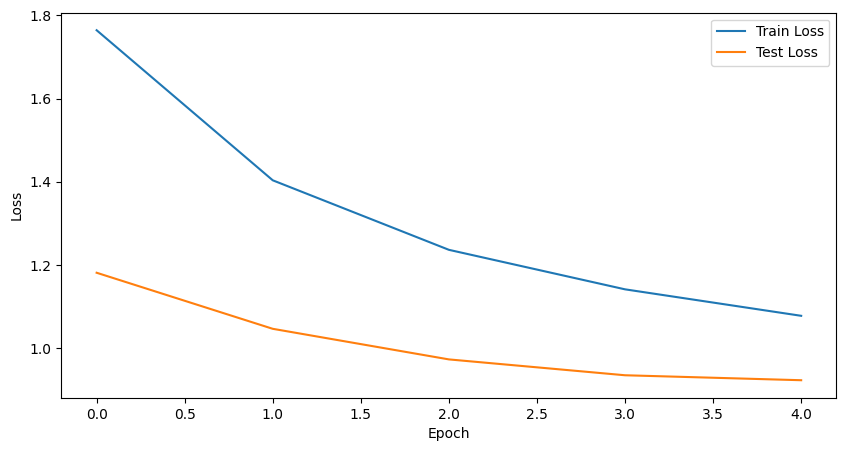

In [15]:
# Plot the loss curves
plt.figure(figsize=(10, 5))
plt.plot(train_loss_history_resnet18, label="Train Loss")
plt.plot(test_loss_history_resnet18, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Model Evaluation ###

Load the saved model and evaluate model performance on the testing dataset

In [10]:
# Reinitialize the model
model_resnet18 = ResNet18_CIFAR10()

# Load the saved weights
model_resnet18.load_state_dict(torch.load('./cifar_resnet18.pth'))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_resnet18 = model_resnet18.to(device)

test_loss, test_accuracy, all_labels, all_predictions, all_probs = test(model_resnet18, device, testloader, criterion)

Testing: 100%|██████████| 2500/2500 [00:28<00:00, 87.97it/s] 

Test Loss: 0.9233, Test Accuracy: 72.53%


In [11]:
from sklearn.metrics import classification_report, accuracy_score
report = classification_report(all_labels, all_predictions, target_names=classes)
print("\nClassification Report:\n")
print(report)


Classification Report:

              precision    recall  f1-score   support

       plane       0.52      0.88      0.66      1000
         car       0.88      0.84      0.86      1000
        bird       0.68      0.64      0.66      1000
         cat       0.54      0.60      0.57      1000
        deer       0.72      0.69      0.70      1000
         dog       0.76      0.56      0.64      1000
        frog       0.87      0.72      0.79      1000
       horse       0.78      0.78      0.78      1000
        ship       0.84      0.77      0.81      1000
       truck       0.90      0.77      0.83      1000

    accuracy                           0.73     10000
   macro avg       0.75      0.73      0.73     10000
weighted avg       0.75      0.73      0.73     10000



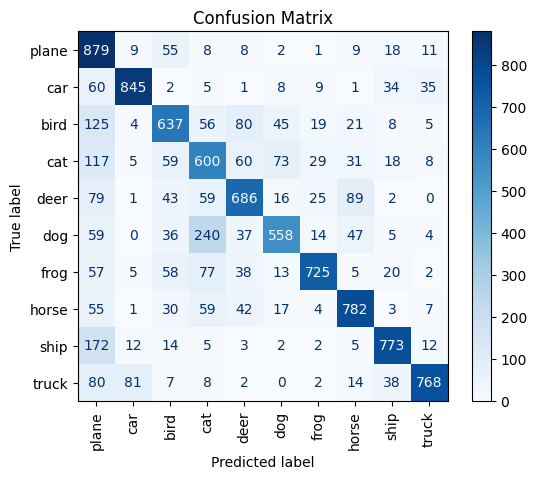

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Compute confusion matrix
cm = confusion_matrix(all_labels, all_predictions)
# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')

plt.title("Confusion Matrix")
plt.show()

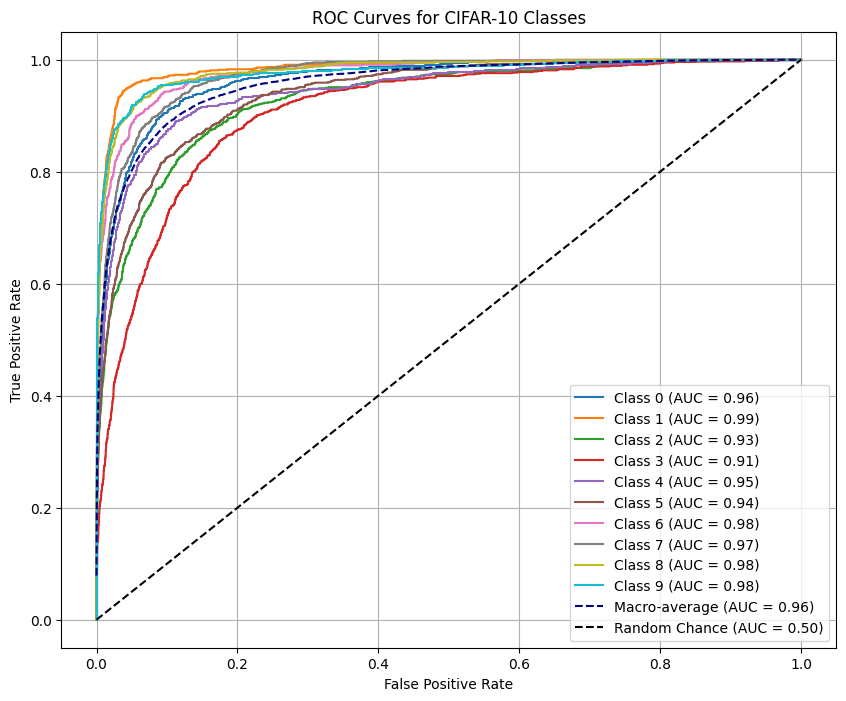

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Number of classes
num_classes = 10

all_probs = np.vstack(all_probs)
all_labels = np.hstack(all_labels)

# Binarize the labels for multi-class ROC
all_labels_binarized = label_binarize(all_labels, classes=np.arange(num_classes))

# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(all_labels_binarized[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute macro-average ROC curve and AUC
fpr["macro"], tpr["macro"] = np.unique(np.concatenate([fpr[i] for i in range(num_classes)])), None
tpr["macro"] = np.mean([np.interp(fpr["macro"], fpr[i], tpr[i]) for i in range(num_classes)], axis=0)
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot the ROC curves
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")
plt.plot(fpr["macro"], tpr["macro"], color='navy', linestyle='--', label=f"Macro-average (AUC = {roc_auc['macro']:.2f})")

# Diagonal line for random chance
plt.plot([0, 1], [0, 1], 'k--', label="Random Chance (AUC = 0.50)")
plt.title("ROC Curves for CIFAR-10 Classes")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()

## Use other models ##

**The torchvision.models package in Pytorch contains definitions for the following model architectures for image classification: https://pytorch.org/vision/0.8/models.html**

In [ ]:
#TODO: Use different pretrained model to train the model